# 🧬 Patch Camelyon (PCam) Deep Learning Pipeline

Welcome to the first part of the series! In this notebook, we'll create a basic deep learning pipeline for the PCam dataset. We'll start by exploring the data, then build a PyTorch dataset, design a model, and implement the training loop. Let's get started!

### About the PCam Dataset 📊

The Patch Camelyon (PCam) dataset consists of 327,680 image patches, each 96x96 pixels, extracted from histopathologic scans of lymph node sections. Each patch is labeled as either **benign** (no tumor) or **malignant** (contains tumor). The goal is to accurately classify these patches.

PCam is derived from the larger Camelyon16 Challenge, which features whole-slide images (WSIs) of lymph node sections stained with H&E. For PCam, these slides were digitized, and the images were undersampled to provide a larger field of view at a lower resolution. A positive label in PCam means that the central 32x32 pixel region of a patch contains tumor tissue, ensuring consistent behavior of the model when applied to a whole-slide image.

![PCam example images. Green boxes indicate positive labels.](https://github.com/basveeling/pcam/blob/master/pcam.jpg?raw=true)

*Example images from PCam. Green boxes indicate tumor tissue in center region, which dictates a positive label.*


### Notebook Structure 📚

1. Data Exploration 🔍
2. Augmentations ✨
3. Building a PyTorch Dataset 🛠️
4. Designing the Model 🧠
5. Setting up Loss Functions, Optimizers, and Metrics ⚖️
6. Building a LightningModule 🌩
7. Implementing the Training Loop 🚀

This notebook is designed to be both a practical guide and a learning resource, helping you build a deep learning model from scratch while also understanding the underlying principles. Let's dive in!

**Authors:**<br>
&copy; 2024; Matěj Pekár, Vít Musil

In [2]:
!pip install torch lightning tqdm albumentations torchvision torchmetrics torcheval numpy matplotlib

  Using cached torch-2.4.0-cp311-cp311-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached lightning-2.4.0-py3-none-any.whl.metadata (38 kB)
  Using cached tqdm-4.66.5-py3-none-any.whl.metadata (57 kB)
  Using cached albumentations-1.4.14-py3-none-any.whl.metadata (38 kB)
  Using cached torchvision-0.19.0-cp311-cp311-manylinux1_x86_64.whl.metadata (6.0 kB)
  Using cached torchmetrics-1.4.1-py3-none-any.whl.metadata (20 kB)
  Using cached torcheval-0.0.7-py3-none-any.whl.metadata (8.6 kB)
  Using cached filelock-3.15.4-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.13.2-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached fsspec-2024.6.1-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none

## 1. Data Exploration 🔍

In this section, we'll begin by exploring the data provided for the Patch Camelyon (PCam) challenge. Understanding the dataset is crucial before diving into model training.

### Dataset Overview

The original dataset is stored in the `hdf5` format, a common format for large-scale data. However, to simplify our workflow, we've converted the data into `numpy` arrays. These arrays make it easier to manipulate and explore the data using Python.

The dataset is split into three subsets:

- **Training Set** (80%) - Used to train the model.
- **Validation Set** (10%) -  Used to tune model hyperparameters and avoid overfitting.
- **Test Set** (10%) - Used to evaluate the final model performance.


Each subset consists of two numpy arrays:

1. **Images** - Stored as 4D arrays with dimensions `(N x 96 x 96 x 3)`, where `N` is the number of samples. Each image is 96x96 pixels with 3 color channels (RGB).
2. **Labels** - Stored as 1D arrays with `N` labels, where each label indicates whether the corresponding image is benign (0) or malignant (1).

Given the large size of the dataset, we'll use `numpy`'s memory-mapped files (`mmap`) to load the data efficiently. This approach allows us to work with large datasets without loading everything into memory at once.

### Let's Get Started!

We'll begin by loading the data and taking a closer look at the images and labels to understand their structure and distribution. This exploration will set the stage for the subsequent steps of data loader, model design, and training.

In [3]:
import numpy as np


TRAIN_X_PATH = "/mnt/data/PatchCamelyon/camelyonpatch_level_2_split_train_x.npy"
TRAIN_Y_PATH = "/mnt/data/PatchCamelyon/camelyonpatch_level_2_split_train_y.npy"

VALID_X_PATH = "/mnt/data/PatchCamelyon/camelyonpatch_level_2_split_valid_x.npy"
VALID_Y_PATH = "/mnt/data/PatchCamelyon/camelyonpatch_level_2_split_valid_y.npy"

TEST_X_PATH = "/mnt/data/PatchCamelyon/camelyonpatch_level_2_split_test_x.npy"
TEST_Y_PATH = "/mnt/data/PatchCamelyon/camelyonpatch_level_2_split_test_y.npy"



train_x = np.load(TRAIN_X_PATH, mmap_mode="w+")
train_y = np.load(TRAIN_Y_PATH, mmap_mode="w+")

val_x = np.load(VALID_X_PATH, mmap_mode="w+")
val_y = np.load(VALID_Y_PATH, mmap_mode="w+")

test_x = np.load(TEST_X_PATH, mmap_mode="w+")
test_y = np.load(TEST_Y_PATH, mmap_mode="w+")

print("train_x:", train_x.shape)
print("train_y:", train_y.shape)
print("val_x:", val_x.shape)
print("val_y:", val_y.shape)
print("test_x:", test_x.shape)
print("test_y:", test_y.shape)

PermissionError: [Errno 13] Permission denied: '/mnt/data/PatchCamelyon/camelyonpatch_level_2_split_train_x.npy'

Let’s take a look at a few sample images from the training set along with their corresponding labels. This will give us a better sense of what the data looks like. Feel free to rerun the cell to view different images each time!

While we're not pathologists and may not be able to precisely interpret the medical details in these images, we can still observe visual differences between the benign and malignant patches. These differences will be key for our model to learn and distinguish between the two classes.

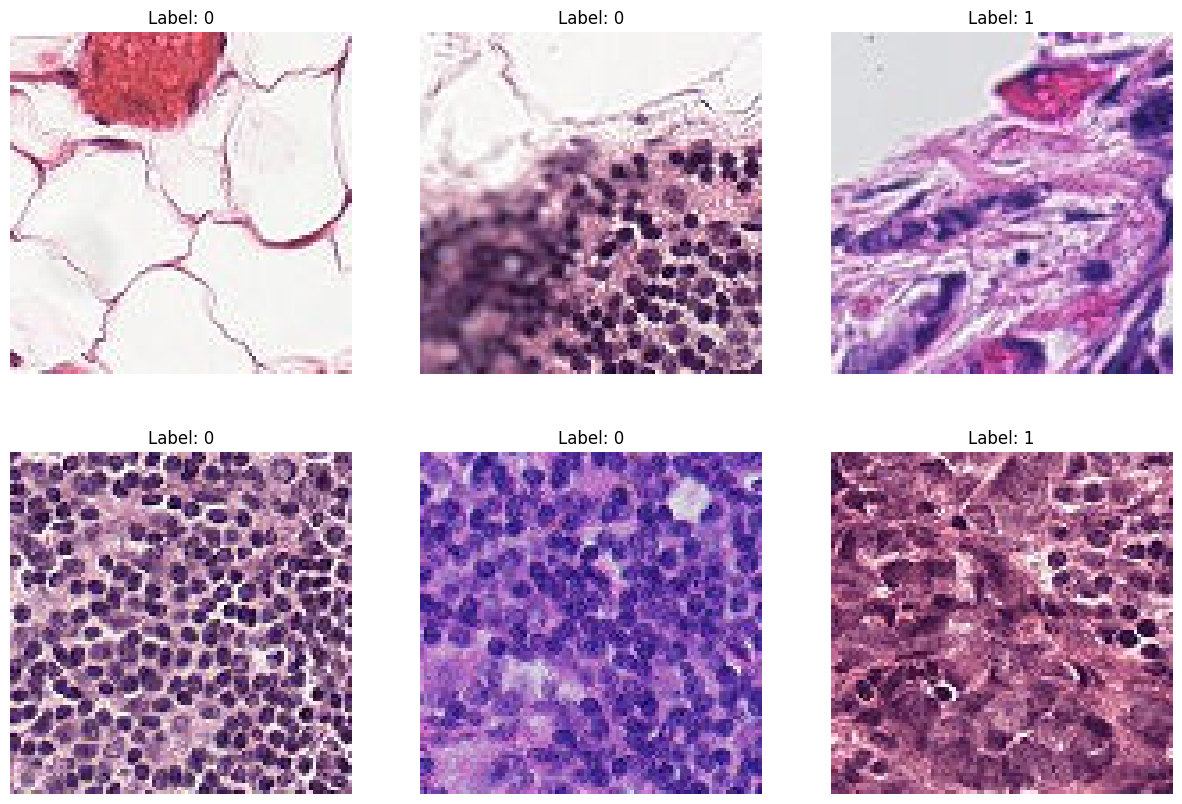

In [3]:
import random

import matplotlib.pyplot as plt


# Select 6 random indices
random_indices = random.sample(range(len(train_x)), 6)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, idx in zip(axes.flatten(), random_indices, strict=True):
    x, y = train_x[idx], train_y[idx]
    ax.imshow(x)
    ax.set_title(f"Label: {y.item()}")
    ax.axis("off")

plt.show()

Next, let’s dive into the distribution of labels across our training, validation, and test sets. This step is important because it helps us understand whether our dataset is balanced between benign and malignant patches.

If the data is imbalanced (meaning one label significantly outnumbers the other) our model might become biased towards the more frequent class. This could lead to poor performance, especially on the minority class. To address this, we might need to consider [techniques](https://developers.google.com/machine-learning/crash-course/overfitting/imbalanced-datasets) like:
- **Oversampling** the minority class.
- **Undersampling** the majority class.
- Using a **weighted loss function** to give more importance to the minority class.

Understanding the label distribution is also crucial for ensuring that our validation and test sets are representative of the training data. If these sets have similar distributions, we can be more confident that our model’s performance during training will generalize well to unseen data.

Let’s see what we’re working with!

In [4]:
print("train:", np.unique(train_y, return_counts=True))
print("val:", np.unique(val_y, return_counts=True))
print("test:", np.unique(test_y, return_counts=True))

train: (array([0, 1], dtype=uint8), array([131072, 131072]))
val: (array([0, 1], dtype=uint8), array([16399, 16369]))
test: (array([0, 1], dtype=uint8), array([16391, 16377]))


Great news! The data in our training, validation, and test sets is well-balanced! This means our model should be able to learn effectively without having to deal with biases towards any particular class. 🎉

Next up, we'll calculate the **mean** and **standard deviation** for each color channel (Red, Green, Blue) across the training set images. These values are crucial for normalizing our images. Normalization adjusts the pixel values so that they have a mean of 0 and a standard deviation of 1. This speeds up model convergence and stabilizes the gradients during training.


>**_NOTE:_**  We’ll compute these statistics using the training set and then apply the same normalization to the validation and test sets to ensure fairness in our evaluation.

<div class="alert alert-success">
    <h3>TASK 1.01</h3>
    <p>
        Calculate the mean and standard deviation for each color channel (Red, Green, Blue) across the subset of the training set images. While we’ve pre-calculated these values for the entire training set for you, your task is to compute them for a subset. The results should be close to the pre-calculated values.
    </p>
</div>

In [5]:
subset_x = train_x[:1000]

train_x_mean = np.mean(subset_x, axis=(0,1,2))
train_x_std = np.std(subset_x, axis=(0,1,2))

print("mean:", train_x_mean)
print("std:", train_x_std)


# Pre-calculated values for whole dataset
train_x_mean = [178.69278045, 137.28123996, 176.36324185]
train_x_std = [59.91942025, 70.73932419, 54.28812066]

mean: [178.03038249 137.12479709 175.87032313]
std: [60.24165906 71.17093412 54.71606427]


## 2. Augmentations ✨

In this section, we'll explore how to boost the size and diversity of our training set using image augmentation. Augmentation involves applying random transformations to our images, which helps create a more varied dataset. This process improves the model's ability to generalize and reduces the risk of overfitting.

We'll be using the powerful Albumentations library for our augmentations. [Albumentations](https://albumentations.ai) offers a wide range of techniques to transform our images, from simple operations like rotations and flips to more advanced techniques.


<style>
code {
    color: purple;
}
</style>

<div class="alert alert-success">
    <h3>TASK 2.01</h3>
    <p>
        See the <a href="https://albumentations.ai/docs/">Albumentations documentation</a> and select transformations that are suitable for pathology images. Try to choose at least 4-5 augmentations that can enhance the model’s generalization ability. Remember, the last transformation should be <code>Normalize</code>, using the mean and standard deviation you calculated earlier. For testing, use only the <code>Normalize</code> transformation to ensure consistency.
    </p>
</div>

In [6]:
import albumentations as A


train_transforms = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1),
        A.RandomRotate90(),
        A.Flip(),
        A.Normalize(mean=train_x_mean, std=train_x_std)
    ]
)

# test_transforms will be applied to validation and test sets
test_transforms = A.Normalize(mean=train_x_mean, 
                              std=train_x_std, 
                              max_pixel_value=1) # This will be applied to validation and test sets

Let's test out your augmentations using the code below! This is your chance to experiment with different transformations and parameters to see how they impact the images. It’s a great way to fine-tune your augmentation strategy and understand how each change affects the data.

>**_NOTE:_** For better visualization, we’re temporarily skipping the final normalization step so you can clearly see the effects of the augmentations.

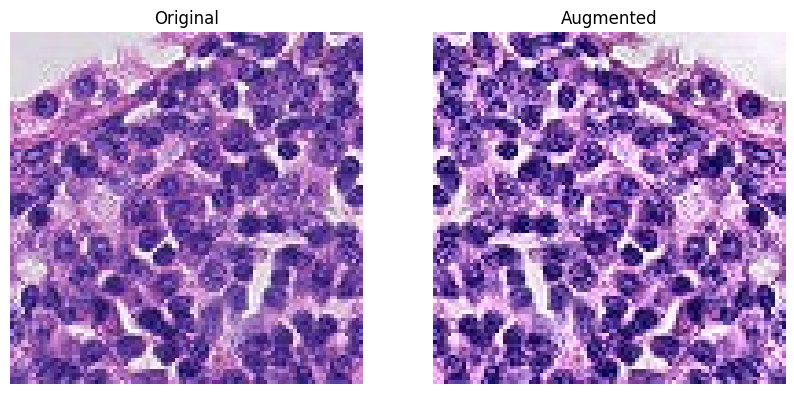

In [7]:
original_image = train_x[0]

# Transformed image
transforms = A.Compose(train_transforms.transforms[:-1])
augmented_image = transforms(image=original_image)["image"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display original image
axes[0].imshow(original_image)
axes[0].set_title("Original")
axes[0].axis("off")

# Display augmented image
axes[1].imshow(augmented_image)
axes[1].set_title("Augmented")
axes[1].axis("off")

plt.show()

## 3. Building a PyTorch Dataset 🛠️

In this section, we'll create a custom PyTorch Dataset to load and preprocess our PCam data. This dataset will handle loading the images, applying augmentations, normalizing the data, and returning the images along with their corresponding labels.


<style>
code {
    color: purple;
}
</style>

<div class="alert alert-success">
    <h3>TASK 3.01</h3>
    <p>
        Implement the <code>PCamDataset</code> class by completing the <code>__init__</code>, <code>__len__</code>, and <code>__getitem__</code> methods. This class will load the images and labels and normalize the data.
    </p>
</div>

In [8]:
from typing import TypeAlias

from albumentations import TransformType
from torch import Tensor
from torch.utils.data import Dataset


Sample: TypeAlias = tuple[Tensor, Tensor]


class PatchCamelyon(Dataset[Sample]):
    def __init__(self, path_x: str, path_y: str, transforms: TransformType | None = None) -> None:
        """Initialize the dataset.

        Args:
            path_x: Path to the numpy file containing the images.
            path_y: Path to the numpy file containing the labels.
            transforms: Albumentations transforms to apply to the images.
        """
        super().__init__()
        self.images = np.load(path_x, mmap_mode="r")
        self.path_y = np.load(path_y, mmap_mode="r")
        self.transforms = transforms
        self.to_tensor = ToTensorV2()

    def __len__(self) -> int:
        """Return the number of samples in the dataset."""
        return len(self.images)

    def __getitem__(self, index: int) -> Sample:
        """Return the sample at the given index.

        Args:
            index: Index of the sample to return.

        Returns:
            Tuple containing the image and the label.
            Image is a tensor of shape (C, H, W) and label is a tensor of shape (1,).
        """
        img = self.images[index]
        if self.transforms is not None:
            image = self.transforms(image=image)["image"]
        
        return self.to_tensor(image=image)["image"], torch.tensor(label).float()

You can test your implementation by running the code below. Keep in mind that if your augmentations are too extreme, you might encounter errors, especially if the resulting **mean** and **standard deviation** stray too far from expected values.

This is a great opportunity to fine-tune your transformations—aim for augmentations that are impactful yet still keep your data within a reasonable range.

In [ ]:
import torch
from torch.utils.data import DataLoader


batch_size = 512


def test_dataset(dataset: Dataset[Sample]) -> None:
    for inputs, targets in DataLoader(dataset, batch_size=batch_size, drop_last=True):
        assert isinstance(targets, torch.Tensor)
        assert targets.dtype == torch.float32
        assert targets.shape == (batch_size, 1)
        
        assert isinstance(inputs, torch.Tensor)
        assert inputs.dtype == torch.float32
        assert inputs.shape == (batch_size, 3, 96, 96)

        # Check that the mean and std are close to 0 and 1 respectively
        assert torch.isclose(
            inputs.mean((0, 2, 3)), torch.zeros(3), rtol=0.2, atol=0.2
        ).all()
        assert torch.isclose(inputs.std((0, 2, 3)), torch.ones(3), rtol=0.2, atol=0.2).all()
        break


train_dataset = PatchCamelyon(
    path_x=TRAIN_X_PATH,
    path_y=TRAIN_Y_PATH,
    transforms=train_transforms,
)

val_dataset = PatchCamelyon(
    path_x=VALID_X_PATH,
    path_y=VALID_Y_PATH,
    transforms=train_transforms,
)

test_dataset(train_dataset)
test_dataset(val_dataset)

Finally, let’s enhance our data pipeline by wrapping our custom dataset in a `LightningDataModule`. This class is integral to **PyTorch Lightning** and streamlines the process of managing data across different stages of model training and evaluation.

#### Key Components

- **`setup` method**: This method is crucial for initializing the data based on the current `stage` (whether it’s fit, validate, test, or predict). It’s responsible for loading and preparing the datasets for the corresponding phase of the training pipeline.

- **Dataloader Methods**: The `LightningDataModule` provides four key methods to access the data:
    - `train_dataloader`: Returns the DataLoader for the training set.
    - `val_dataloader`: Returns the DataLoader for the validation set.
    - `test_dataloader`: Returns the DataLoader for the test set.
    - `predict_dataloader`: Returns the DataLoader for making predictions.

This structure keeps our data management modular and scalable, aligning with best practices in deep learning workflows.

<style>
.code {
    code {
        color: purple;
    }
}

</style>

<div class="alert alert-success code">
    <h3>TASK 3.02</h3>
    <p>
        Complete the <code>DataModule</code>. Remember to apply normalization to the validation and test sets and augmentation only to the training set. Use the ones you have already implemented.
    </p>
</div>

In [ ]:
from collections.abc import Iterable

from lightning import LightningDataModule


Input: TypeAlias = tuple[Tensor, Tensor]


class DataModule(LightningDataModule):
    def __init__(self, batch_size: int, num_workers: int = 0) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage: str) -> None:
        match stage:
            case "fit":
                self.train = PatchCamelyon(
                    path_x=TRAIN_X_PATH,
                    path_y=TRAIN_Y_PATH,
                    transforms=train_transforms,
                )
                self.val = PatchCamelyon(
                    path_x=VALID_X_PATH,
                    path_y=VALID_Y_PATH,
                    transforms=test_transforms,
                )
            case "validate":
                self.val = PatchCamelyon(
                    path_x=VALID_X_PATH,
                    path_y=VALID_Y_PATH,
                    transforms=test_transforms,
                )
            case "test":
                self.test = PatchCamelyon(
                    path_x=TEST_X_PATH,
                    path_y=TEST_Y_PATH,
                    transforms=test_transforms,
                )

    def train_dataloader(self) -> Iterable[Input]:
        return DataLoader(
            self.train,
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=True,
            num_workers=self.num_workers,
            persistent_workers=self.num_workers > 0,
        )

    def val_dataloader(self) -> Iterable[Input]:
        return DataLoader(
            self.val,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            persistent_workers=self.num_workers > 0,
        )

    def test_dataloader(self) -> Iterable[Input]:
        return DataLoader(
            self.test, 
            batch_size=self.batch_size, 
            num_workers=self.num_workers
        )

## 4. Designing the Model 🧠

Now it’s time to design our model! We'll be building it in two main parts: the **backbone** (the feature extractor) and the **classifier head**.

### Backbone

Luckily, we don’t have to build this from scratch! The [torchvision](https://pytorch.org/vision/stable/models.html) library provides a variety of pre-trained backbones, such as **VGG** and **ResNet**. These models have already been trained on large datasets, so they come with weights that can give our model a head start.

You can choose any of these backbones to use as your feature extractor, but make sure to only use the feature extraction part of the model. Leave out the classifier head that comes with it! This way, we can add our own custom classifier head suited for the PCam challenge.

<div class="alert alert-success">
    <h3>TASK 4.01</h3>
    <p>
        Implement the backbone of your model using a model from the <a href="https://pytorch.org/vision/stable/models.html">torchvision</a> library. Preferably use a smaller CNN model.
    </p>
</div>

In [ ]:
from torch import nn


def build_backbone() -> nn.Module:
    return torchvision.models.vgg16(weights=None).features

### Classifier Head

Now it’s time to build the classifier head, the part of the model that takes the feature vector from the backbone and makes the final decision: benign or malignant.


This section is where we transform the rich features extracted by the backbone into a simple binary classification. The classifier head will process the features and output a single value that indicates the probability of the image being malignant.

<div class="alert alert-success">
    <h3>TASK 4.02</h3>
    <p>
        Your task is to implement the classifier head of the model. Here are some layers that might come in handy: <b>nn.AdaptiveAvgPool2d</b> (for pooling the features), <b>nn.Dropout</b> (to prevent overfitting), <b>nn.Linear</b> (for the final classification), and <b>nn.Sigmoid</b> (to convert the output into a probability).
    </p>
</div>

In [ ]:
from torch import Tensor, nn


class BinaryClassifier(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=0.5)
        self.proj = nn.Linear(512, 1)

    def forward(self, x: Tensor) -> Tensor:
        x = self.global_pool(x)  # (B, C, 1, 1)
        x = x.flatten(start_dim=-3, end_dim=-1)  # (B, C)
        x = self.dropout(x)
        x = self.proj(x)
        return x.sigmoid()

And finally, we'll combine the backbone and classifier head to create our full model. This model will be trained to classify the PCam images as benign or malignant.

In [ ]:

backbone = build_backbone()
classifier = BinaryClassifier()

inputs = torch.randn(5, 3, 96, 96)
features = backbone(inputs)
outputs = classifier(features)

assert outputs.shape == (5, 1)

## 5. Setting up Loss Functions, Optimizer, and Metrics  ⚖️

### Loss Function

The loss function is a crucial component of our model. It quantifies how well our model is performing by comparing the predicted labels with the actual labels. During training, our goal is to minimize this loss.

Picking the right loss function is key to guiding your model toward better performance, so take a moment to explore the options and choose the one that best fits our needs.

<div class="alert alert-success">
    <h3>TASK 5.01</h3>
    <p>
        Select an appropriate loss function from <a href="https://pytorch.org/docs/stable/nn.html#loss-functions">PyTorch's list</a> of options that best suits our binary classification task.
    </p>
</div>

In [ ]:
criterion = nn.BCELoss() # TODO

### Optimizer

The optimizer is responsible for updating the model’s weights based on the gradients calculated during backpropagation, helping the model improve with each iteration. Your choice of optimizer can greatly influence how quickly and effectively the model learns. While **Adam** is a popular and reliable choice, there are plenty of other options to explore depending on your specific needs!


<div class="alert alert-success">
    <h3>TASK 5.02</h3>
    <p>
         Pick an optimizer from <a href="https://pytorch.org/docs/stable/optim.html#algorithms">PyTorch's list</a>. You don't need to specify any hyperparameters yet.
    </p>
</div>

In [ ]:
from torch.optim.optimizer import Optimizer, ParamsT


def build_optimizer(parameters: ParamsT) -> Optimizer:
    return AdamW(
        parameters,
        lr=0.0001,
        betas=(0.9, 0.999),
        weight_decay=0.05,
    )

### Metrics

To truly understand how well our model is performing, we need to select the right metrics. Metrics give us insight into the model's strengths and weaknesses, helping us evaluate its effectiveness beyond just the loss value.

In medical tasks, precision and recall are particularly important because they help us measure how well the model is identifying positive cases (malignant patches) without missing too many or generating too many false alarms. Choosing the right metrics ensures that our model is evaluated on what really matters for the task at hand.

<div class="alert alert-success">
    <h3>TASK 5.03</h3>
    <p>
        Select the appropriate metrics for our binary classification task using the built-in options in the <a href="https://lightning.ai/docs/torchmetrics/stable/">torchmetrics</a> library. Be sure to consider precision and recall, as they are crucial for evaluating performance in medical applications. 
    </p>
</div>

In [ ]:
from torchmetrics import AUROC, Accuracy, Precision, Recall


metrics = nn.ModuleDict(
    {
        "AUC": AUROC("binary"),
        "accuracy": Accuracy("binary"),
        "precision": Precision("binary"),
        "recall": Recall("binary"),
    }
)

## 6. Building a LightningModule 🌩

Now it’s time to bring everything together by combining all our modeling components into a `LightningModule`. This powerful class from PyTorch Lightning streamlines different phases of model training by organizing key processes into specific step methods.

### What Does a LightningModule Do?

The `LightningModule` is the core of PyTorch Lightning. It simplifies and organizes your model’s entire lifecycle, from training to validation and testing. By defining methods like `training_step`, `validation_step`, and `test_step`, you clearly structure your model’s logic for each phase, making the code cleaner and more maintainable.

<style>

.code {
    code {
        color: purple;
    }
}
</style>

<div class="alert alert-success code">
    <h3>TASK 6.01</h3>
    <p>
        Complete the <code>LightningModule</code> by finishing the sections marked with <b>TODO</b>. Use the components (like the model, loss function, and optimizer) that we’ve already defined. This will ensure that all the steps—from forward passes to loss calculations—are correctly implemented and ready to go.
    </p>
</div>

In [ ]:
from collections import defaultdict
from typing import TypeAlias

import torch
from lightning import LightningModule
from torch import Tensor
from torch.optim.optimizer import Optimizer
from torcheval.metrics.functional import mean


Outputs: TypeAlias = Tensor


class PatchCamelyonModel(LightningModule):
    def __init__(self) -> None:
        super().__init__()
        self.backbone = build_backbone()
        self.decode_head = BinaryClassifier()
        self.criterion = criterion
        self.metrics = metrics

        self._validation_bach_sizes: list[int] = []
        self._validation_step_outputs: dict[str, list[Tensor]] = defaultdict(list)

    def forward(self, images: Tensor) -> Outputs:
        features = self.backbone(x)
        return self.decode_head(features)
        
    def training_step(self, batch: Input) -> Tensor:
        inputs, targets = batch
        outputs = self(inputs)

        loss = self.criterion(outputs, targets)
        self.log("train/loss", loss, on_step=True, prog_bar=True)

        return loss

    def validation_step(self, batch: Input) -> None:
        inputs, targets = batch
        outputs = self(inputs)

        loss = self.criterion(outputs, targets)
        self._validation_step_outputs["loss"].append(loss)
        self._validation_bach_sizes.append(len(inputs))

        for metric in self.metrics.values():
            metric(outputs, targets)

    def on_validation_epoch_end(self) -> None:
        weight = torch.tensor(self._validation_bach_sizes, device=self.device)
        avg_outputs = {
            k: mean(torch.stack(v), weight)
            for k, v in self._validation_step_outputs.items()
        }

        log_data = {
            f"validation/{name}": metric.compute()
            for name, metric in self.metrics.items()
        }
        log_data.update({f"validation/{k}": v for k, v in avg_outputs.items()})

        self.log_dict(log_data, sync_dist=True, prog_bar=True)

        self._validation_step_outputs.clear()
        self._validation_bach_sizes.clear()
        for metric in self.metrics.values():
            metric.reset()

    def test_step(self, batch: Input) -> None:
        inputs, targets = batch
        outputs = self(inputs)

        for metric in self.metrics.values():
            metric(outputs, targets)

    def on_test_epoch_end(self) -> None:
        self.log_dict(
            {f"test/{name}": metric.compute() for name, metric in self.metrics.items()},
            sync_dist=True,
        )

        for metric in self.metrics.values():
            metric.reset()

    def configure_optimizers(self) -> Optimizer:

        return build_optimizer(self.parameters())

## 7. Implementing the Training Loop 🚀

Now it’s time to put it all together and train our model! We’ll use PyTorch Lightning’s `Trainer`, which seamlessly integrates our `LightningDataModule` and `LightningModule` to handle the entire training process.

For this initial test run, we’ll limit the training and validation data to just 50 batches. This will help us quickly verify that everything is working correctly without the need for a full-scale training session.

In [ ]:
from lightning import Trainer


# instantiate the datamodule
datamodule = DataModule(batch_size=128)

# instantiate the model
model = PatchCamelyonModel()

# instantiate the trainer
trainer = Trainer(
    max_epochs=3,
    limit_train_batches=50, 
    limit_val_batches=50,
)

# train the model
trainer.fit(model, datamodule)

And finally, run the model on the test set to evaluate the model's performance on unseen data. This will give us a clear picture of how well our model generalizes to new samples.

In [ ]:
trainer.test(model, datamodule)